In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def merge_dfs(dfs: list[pd.DataFrame]):
    out_df = dfs[0]

    for i in range(1, len(dfs)):
        out_df = pd.merge(out_df, dfs[i], how="left", on=["Country", "Date"])

    return out_df


def generate_indications_cols(df: pd.DataFrame, num_ind: int, label: str, filler):
    new_cols = pd.DataFrame.from_dict([
        {
            f"{label}_ind{indication_num}": filler
                for indication_num in range(1, num_ind+1)
        } 
        for _ in range(len(df))
    ], dtype=float)

    return pd.concat([ df, new_cols ], axis=1)

def fix_date_missing_period(df: pd.DataFrame, col_name="Date"):
    month_map = {
        "janv": "Jan",
        "févr": "Feb",
        "mars": "Mar",
        "avr": "Apr",
        "mai": "May",
        "juin": "Jun",
        "juil": "Jul",
        "août": "Aug",
        "sept": "Sep",
        "oct": "Oct",
        "nov": "Nov",
        "déc": "Dec"
    }
    df[col_name] = df[col_name].apply(lambda x: f"{month_map[x.split('-')[0]]}-{x.split('-')[1]}")
    df[col_name] = pd.to_datetime(df[col_name], format="%b-%y")
    return df


def clean_innovix_ex_factory_vol(df: pd.DataFrame):
    df.drop(columns=["Data type", "Unit of measure"], inplace=True)
    df.rename(columns={"Value": "ex_factory_volumes"}, inplace=True)
    return df

def clean_innovix_demand_volumes(df: pd.DataFrame, products):
    df.drop(index=df.index[df["Unit of measure"] == "Milligrams"], inplace=True)
    df.drop(columns=["Data type", "Unit of measure"], inplace=True)

    for prod in products:
        df[f"{prod}_months_of_treatment"] = 0.0

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_months_of_treatment"] = row["Value"]

    df.drop(columns=["Value"], inplace=True)

    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country

    return df

def clean_innovix_activity(df: pd.DataFrame, num_ind: int, products: list[str]):
    channel_name_map = {
        "Face to face call": "face-to-face-call", 
        "Email": "email", 
        "Remote call": "remote-call", 
        "Meetings": "meetings"
    }
    df["Channel"] = df["Channel"].map(channel_name_map)
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")

    for prod in products:
        for channel in df["Channel"].unique().tolist():
            df = generate_indications_cols(df, num_ind, f"{prod}_{channel}", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_{row['Channel']}_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Product", "Channel", "Indication", "Value"], inplace = True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country

    return df

def clean_innovix_share_of_voice(df: pd.DataFrame, num_ind: int, products):
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")
    for prod in products:
        df = generate_indications_cols(df, num_ind, f"{prod}_share_of_voice", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_share_of_voice_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Indication", "Product", "Value", "Product"], inplace=True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country
    return df

def clean_innovix_new_patient_share(df: pd.DataFrame, num_ind: int, products):
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")
    for prod in products:
        df = generate_indications_cols(df, num_ind, f"{prod}_new_patient_shape", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_new_patient_shape_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Indication", "Product", "Sub-Indication", "Value"], inplace=True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country
    return df


def clean_innovix_indication_split(df: pd.DataFrame, num_ind: int, products):
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")
    for prod in products:
        df = generate_indications_cols(df, num_ind, f"{prod}_indication_split", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_indication_split_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Indication", "Product", "Sub-Indication", "Value"], inplace=True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country
    return df


df_floresland_ex_factory_vol = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="Ex-Factory volumes")
df_floresland_demand_volumes = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="Demand volumes")
df_floresland_activity = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="Activity")
df_floresland_share_of_voice = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="Share of Voice")
df_floresland_new_patient_share = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="New patient share")
df_floresland_new_patient_share = fix_date_missing_period(df_floresland_new_patient_share)
df_floresland_indication_split = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="Indication split")



NUM_IND = max(
    max([int(x.split(" ")[1]) for x in df_floresland_activity["Indication"].unique()]),
    max([int(x.split(" ")[1]) for x in df_floresland_share_of_voice["Indication"].unique()]),
    max([int(x.split(" ")[1]) for x in df_floresland_new_patient_share["Indication"].unique()]),
    max([int(x.split(" ")[1]) for x in df_floresland_indication_split["Indication"].unique()])
)
PRODUCTS = ["INNOVIX", "YREX"]


df = merge_dfs([
    clean_innovix_ex_factory_vol(df_floresland_ex_factory_vol),
    clean_innovix_demand_volumes(df_floresland_demand_volumes, products=PRODUCTS),
    clean_innovix_activity(df_floresland_activity, NUM_IND, products=PRODUCTS),
    clean_innovix_share_of_voice(df_floresland_share_of_voice, NUM_IND, products=PRODUCTS),
    clean_innovix_new_patient_share(df_floresland_new_patient_share, NUM_IND, products=PRODUCTS),
    clean_innovix_indication_split(df_floresland_indication_split, NUM_IND, products=PRODUCTS)
])

In [3]:
df_truth = pd.read_excel("src/data/INNOVIX_Floresland.xlsx", sheet_name="Forecast volumes")
display(df_truth["Forecast Algorithm"].unique())

algo = "optimized arima"

df_truth = df_truth[ df_truth["Forecast Algorithm"] == algo ]
df_truth = df_truth[ df_truth["Data period"] == "Monthly" ]

display(df_truth)

array(['optimized tslmx', 'optimized arima', 'univariate xgboost',
       'multivariate xgboost', 'optimized ets', 'univariate arima',
       'optimized tbats'], dtype=object)

,Country,Product,Data type,Forecast Algorithm,Data period,Date,Value
84,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2024-11-01,4.187574e+06
85,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2024-12-01,4.227316e+06
86,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-01-01,5.214774e+06
87,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-02-01,4.646591e+06
88,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-03-01,4.815716e+06
89,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-04-01,4.344956e+06
90,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-05-01,4.406519e+06
91,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-06-01,4.089633e+06
92,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-07-01,4.361719e+06
93,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-08-01,4.427256e+06


In [4]:
df.drop(columns=["Country", "Product"], inplace=True)
df = df.sort_values(by="Date")

In [5]:
import numpy as np
df["Date"] = np.arange(0, len(df["Date"]))

In [6]:
df

,Date,ex_factory_volumes,INNOVIX_months_of_treatment,YREX_months_of_treatment,INNOVIX_face-to-face-call_ind1,INNOVIX_face-to-face-call_ind2,INNOVIX_face-to-face-call_ind3,INNOVIX_face-to-face-call_ind4,INNOVIX_face-to-face-call_ind5,INNOVIX_face-to-face-call_ind6,...,YREX_indication_split_ind14,YREX_indication_split_ind15,YREX_indication_split_ind16,YREX_indication_split_ind17,YREX_indication_split_ind18,YREX_indication_split_ind19,YREX_indication_split_ind20,YREX_indication_split_ind21,YREX_indication_split_ind22,YREX_indication_split_ind23
0,0,3503180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2611020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2952120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2995280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2929660,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,3967620,7707.728375,23359.408837,377.0,168.0,0.0,0.0,0.0,0.0,...,0.017831,0.0,0.0,0.0,0.0,0.571180,0.006816,0.0,0.0,0.045567
78,78,4932260,9653.302392,28975.411650,158.0,287.0,0.0,0.0,0.0,0.0,...,0.013297,0.0,0.0,0.0,0.0,0.536082,0.013918,0.0,0.0,0.049469
79,79,4063420,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,80,4464140,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern


# kernel = WhiteKernel(0.1)
# kernel += ConstantKernel(1) * RBF(1, (-1e, 1e2))
# kernel += ConstantKernel(1) * DotProduct(1)

kernel = WhiteKernel(0.1, (1e-9, 1e9))
kernel += ConstantKernel(1, (1e-9, 1e9)) * RBF(1, (1e-9, 1e9))
kernel += ConstantKernel(1, (1e-9, 1e9)) * DotProduct(1, (1e-9, 1e9))


# # dff = df.dropna()
# dff = df
# X = dff.drop(columns=["ex_factory_volumes"])
# y = dff["ex_factory_volumes"]


# print("ex_factory_volumes" in X.columns, X.shape)

# X = X.fillna(X.mean())
# # X = pd.DataFrame(X["Date"])

# th = 10

# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
# gp.fit(X.iloc[:-th], y.iloc[:-th])

# pred, std = gp.predict(X.iloc[-th:], return_std=True)
# print( pred )
# print( std*1.96 )
# print( y.iloc[-th:].tolist() )

In [9]:
import warnings
from tqdm import tqdm



# dff = df.dropna()
dff = df.set_index(["Date"], drop=False)

X = dff.drop(columns=["ex_factory_volumes"])
y = dff["ex_factory_volumes"]

X = X.fillna(X.mean())
# X = pd.DataFrame(X["Date"])

# th = 10
X = X # Assigns X to X
y = y # Assigns y to y

X = (X-X.mean())/(X.std() + 1e-9)

y_mean = y.mean()
y_std = y.std()
y = (y - y.mean()) / (y.std())



with warnings.catch_warnings(action="ignore"):

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
    # gp.fit(X, y)
    stds = []

    # Test scenario
    # new_sample = {
    #     col: np.random.normal(X[col].mean(), X[col].std(), (1,))[0]
    #     for col in X.columns
    # }
    # new_sample["INNOVIX_months_of_treatment"] *= (1 - 0.1)
    # new_sample["Date"] = 81 + 12

    # sampled_in = pd.DataFrame.from_dict([new_sample])

    # pred, std = gp.predict(sampled_in, return_std=True)
    # pred = pred[0]

    # stds.append(std)

    start_time = int(X.iloc[-1]["Date"]) + 1


    
    # X = pd.concat([ X, pd.DataFrame.from_dict([new_sample]) ])
    # y = pd.concat([ y, pd.Series([pred]) ])




    for _ in tqdm(range(20)):
        # if start_time == 81 + 12:
        #     start_time += 1
        #     continue
            
        gp.fit(X, y)

        new_sample = {
            col: np.random.normal(X[col].mean(), X[col].std(), (1,))[0]
            for col in X.columns
        }
        new_sample["Date"] = start_time

        sampled_in = pd.DataFrame.from_dict([new_sample])

        pred, std = gp.predict(sampled_in, return_std=True)
        pred = pred[0]

        stds.append(std)

        X = pd.concat([ X, pd.DataFrame.from_dict([new_sample]) ])
        y = pd.concat([ y, pd.Series([pred]) ])

        start_time += 1


        # print((pd.DataFrame.from_dict([new_sample]).columns))
        # print((dff.columns))

        # dff.loc[len(dff)] = pd.DataFrame.from_dict([new_sample])


        # dff.append(pd.DataFrame.from_dict([new_sample]))


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


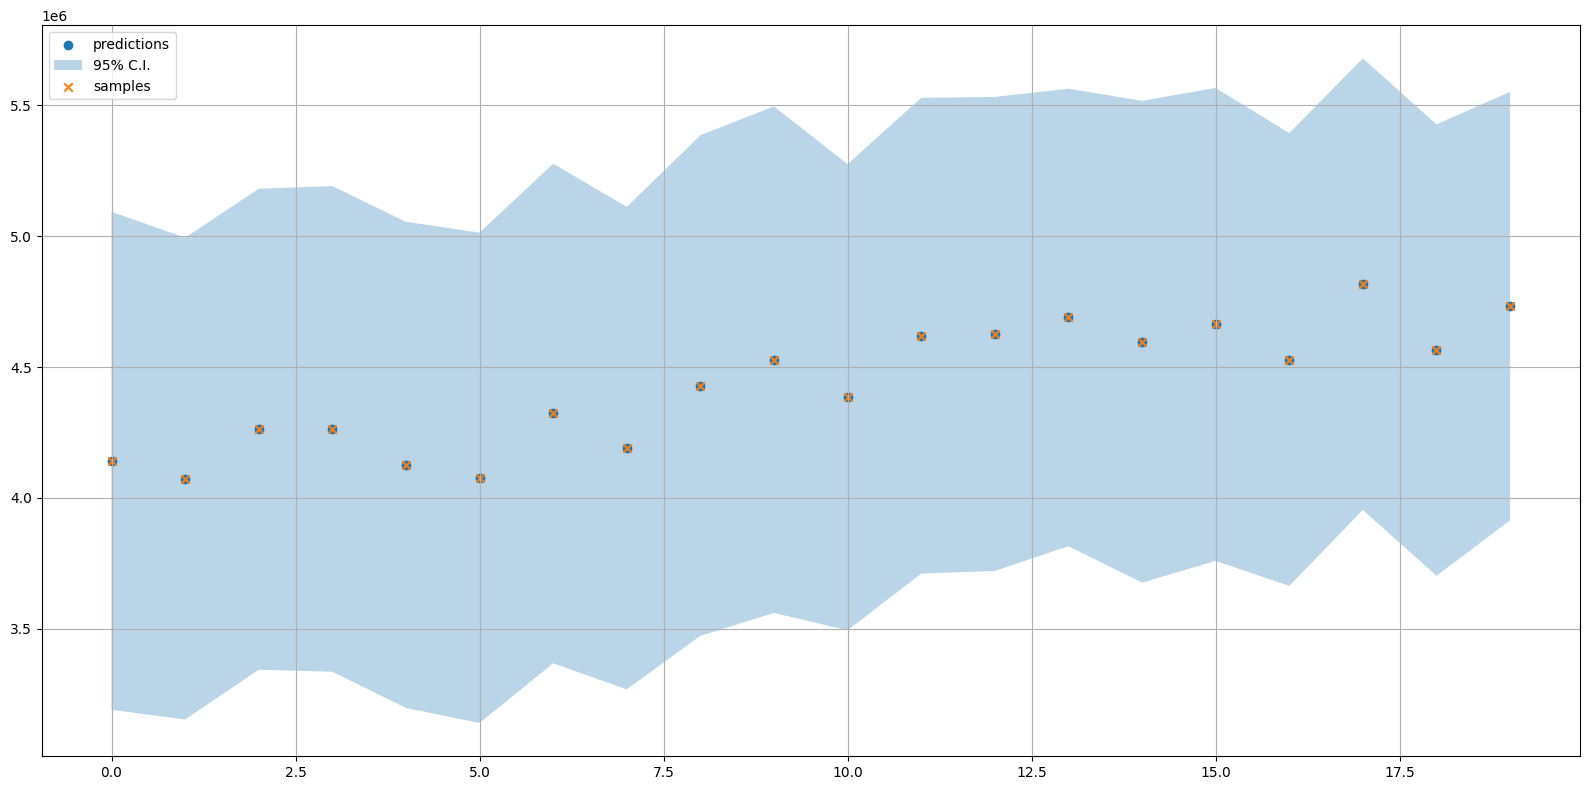

In [12]:
y_denorm = (y * y_std) + y_mean

plot_gp(
    pred = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    samples = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    std = np.array([x[0] for x in stds]) * y_std,
    figsize = (16, 8)
)

# plt.ylim((-1e7, 1e7))
# plt.plot(range(len(df_truth["Value"])), df_truth["Value"])

In [10]:
def plot_gp(target=None, pred=None, std=None, samples=None,
        target_samples=None, figsize=None):
    plt.figure(figsize=figsize)
    if target is not None:
        plt.plot(target.index, target, c='black', label='target')
    if pred is not None:
        plt.scatter(pred.index, pred, c='tab:blue',
                label='predictions')
    if std is not None:
        plt.fill_between(pred.index, pred-1.96*std, pred+1.96*std,
                alpha=.3, fc='tab:blue', ec='None',
                label='95% C.I.')
    # Add scatter plots
    if samples is not None:
        try:
            x = samples.index
            y = samples.values
        except AttributeError:
            x = samples[0]
            y = samples[1]
        plt.scatter(x, y, color='tab:orange',
              label='samples', marker='x')
    if target_samples is not None:
        try:
            x = target_samples.index
            y = target_samples.values
        except AttributeError:
            x = target_samples[0]
            y = target_samples[1]
        plt.scatter(x, y,
                color='black', label='target', s=5)
    plt.legend()
    plt.grid(':')
    plt.tight_layout()